# Cluster AI 2019 - Grupo 7

## Trabajo práctico integrador -  SUACI

**Etapa 02: Clustering** 

In [1]:
# importamos librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importamos librerias de clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

Para el ejercicio de clusterización vamos a basar nuestro análisis en el dataset con los contactos realizados al SUACI en el año calendario 2019. <br>Tomamos esta decisión a partir de la necesidad de reducir la cantidad de samples por el elevado costo computacional de los algoritmos involucrados. Dada esta restricción, elegimos la base 2019 por contar con los datos más recientes.

In [3]:
# importamos el dataset del año 2019
base2019 = pd.read_csv('/Users/fer/Downloads/DATASCIENCE/CLUSTER AI/GRUPO TP/SUACI/sistema-unico-de-atencion-ciudadana-2019.csv', delimiter=',', header = 0, index_col = "contacto")

Para el ejercicio de clusterización nos proponemos trabajar en la identificación de zonas en la Ciudad Autónoma de Buenos Aires con problemáticas similares, definidas las mismas a partir de los contactos realizados al SUACI.
Utilizamos a este efecto la variable "categoría" que aporta una categorización descriptiva del tipo de contacto. <br>
Los contactos realizados al SUACI se catalogan en primer lugar en 213 conceptos, que es el nivel más bajo de categorización. Esos conceptos se agrupan en 58 subcategorías, las cuales a su vez pertenecen a 17 categorías diferentes, siendo éste último el orden superior. <br>
Elegimos trabajar con el nivel de agregación "categoría" porque tiene el nivel de apertura idóneo para trabajar sobre los siguientes objetivos:
- validar el número de clusters óptimo para el algoritmo Kmeans, calculado a partir del Silhouette Score
- encontrar el mínimo valor de k tal que verifique un Silhouette Score por encima de un umbral de corte determinado

Esto último, con el objeto de obtener una categorízación eficiente de zonas de la ciudad con problemáticas similares, dentro de un número de clusters que resulte aún inferior a la división en 15 comunas o 17 categorías.

A efectos del problema propuesto no nos interesa el canal a través del cual se realizó el contacto ni el género del denunciante, así como la fecha en que se registró el mismo, en tanto vamos a tomar el horizonte temporal de todos los contactos realizados durante el año calendario 2019.<br>
Definimos entonces un nuevo dataset con las variables estrictamente importantes para nuestro ejercicio, comprendidas por:
- las variables dummies obtenidas a partir de la variable categórica "categoría"
- el par latitud-longitud, para que el algoritmo le asigne también un peso a la proximidad geográfica de los contactos a la hora de clusterizar

In [4]:
# generamos dummies para la variable "categoría" y los almacenamos en un DF
base_dummies = pd.get_dummies(base2019.categoria)
base_dummies.head(5)

,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,OTRAS,PLUVIALES,RECICLADO Y PROTECCIÓN AMBIENTAL,SALUD Y SERVICIOS SOCIALES,SEGURIDAD,SUGERENCIAS Y LIBRO DE QUEJAS,TRÁMITES Y SERVICIOS,TRÁNSITO
contacto,,,,,,,,,,,,,,,,,
00000001/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000002/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000003/19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00000005/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000006/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
# separamos las variables latitud y longitud
base_coord = base2019.drop(['periodo', 'categoria', 'subcategoria', 'concepto', 'tipo_prestacion', 'fecha_ingreso', 'hora_ingreso', 'domicilio_cgpc', 'domicilio_barrio', 'domicilio_calle', 'domicilio_altura', 'domicilio_esquina_proxima', 'canal', 'genero', 'estado_del_contacto', 'fecha_cierre_contacto'], axis = 1)
base_coord.head(5)

,lat,long
contacto,,
00000001/19,-34.634060,-58.466561
00000002/19,-34.628162,-58.443378
00000003/19,-34.623324,-58.469810
00000005/19,-34.618464,-58.445304
00000006/19,-34.634200,-58.528355


In [6]:
# concatenamos ambos dataframes por columnas
base_cluster = pd.concat([base_coord, base_dummies], axis = 1)
base_cluster.head(5)

,lat,long,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,OTRAS,PLUVIALES,RECICLADO Y PROTECCIÓN AMBIENTAL,SALUD Y SERVICIOS SOCIALES,SEGURIDAD,SUGERENCIAS Y LIBRO DE QUEJAS,TRÁMITES Y SERVICIOS,TRÁNSITO
contacto,,,,,,,,,,,,,,,,,,,
00000001/19,-34.634060,-58.466561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000002/19,-34.628162,-58.443378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000003/19,-34.623324,-58.469810,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00000005/19,-34.618464,-58.445304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000006/19,-34.634200,-58.528355,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [7]:
base_cluster.shape

(626101, 19)

¿Corresponde estandarizar los datos para la clusterización? <br>
El riesgo de no estandarizar es que la diferencia en los órdenes de magnitud de las variables distorsionen las métricas de proximidad del algoritmo de clustering.<br>
Nosotros tenemos por un lado las variables dummies (binarias, con valores 0 y 1), y el par de coordenadas posicionales latitud / longitud. <br>
Las coordenadas latitud y longitud presentan problemas de continuidad (por ejemplo, en el caso del antemeridiano de Greenwich, donde la longitud toma valores de +180 y -180 a ambos lados, representando un salto abrupto en la distancia para dos puntos próximos geográficamente entre sí). Restringiendo el dominio a la Ciudad de Buenos Aires, no tenemos este problema, y por otro lado, al expresar los valores en decimales, la diferencia máxima de los valores en este dominio es inferior a la unidad. Por tanto, no hay diferencias en el orden de magnitud de la diferencia entre las variables. <br>

Para validar esto, vamos a correr un experimento. <br>
Para un valor arbitrario de k, corremos el algoritmo de clusterización sobre nuestro dataset, y en paralelo, sobre la base con el par de coordenadas por un lado, y la base con las variables dummies por otro. <br>
Evaluamos a continuación los scores obtenidos en la clusterización con los datos originales y normalizados, con apertura sobre el tipo de variables involucradas, para estudiar el efecto de la estandarización sobre cada conjunto. <br>

In [8]:
# corremos a continuación modelos de clusterizacion sobre los subconjuntos
# se determina de manera arbitraria k=10 para el nro. de clusters
base10 = KMeans(n_clusters=10, random_state=14).fit(base_cluster)
base10 = base10.labels_
coord10 = KMeans(n_clusters=10, random_state=14).fit(base_coord)
coord10 = coord10.labels_
cat10 = KMeans(n_clusters=10, random_state=14).fit(base_dummies)
cat10 = cat10.labels_

In [10]:
# calculamos el SS para los modelos obtenidos
score_base10 = silhouette_score(base_cluster, base10, sample_size=156525)
score_coord10 = silhouette_score(base_coord, coord10, sample_size=156525)
score_cat10 = silhouette_score(base_dummies, cat10, sample_size=156525)

In [11]:
# comparo los resultados obtenidos
print(score_base10)
print(score_coord10)
print(score_cat10)

0.9296443684085632
0.36617070344028313
0.9675486857271652


In [12]:
# ¿qué pasa si normalizamos las variables?
scaler = preprocessing.StandardScaler().fit(base_cluster)
base_scal = scaler.transform(base_cluster)

In [19]:
print(base_scal.mean(axis=0))
print(base_scal.std(axis=0))

[-8.17018206e-14  3.57657941e-14  3.45000234e-17 -5.99210933e-17
 -1.55704053e-17  4.36924639e-19 -1.08947442e-18  2.71006763e-17
 -5.85592503e-17 -1.82940914e-17 -4.74261835e-17 -1.28807653e-17
  1.52526419e-17 -2.98470597e-17  1.56271488e-17  4.69835845e-17
 -1.78401437e-17  3.34105490e-17  2.76000187e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
# ejercicio, calculo los valores de media y sdv para la base original
print(base_cluster.mean(axis=0))
print(base_cluster.std(axis=0))

lat                                     -34.606402
long                                    -58.451981
ALUMBRADO                                 0.038891
ARBOLADO Y ESPACIOS VERDES                0.076374
CALLES Y VEREDAS                          0.076210
CEMENTERIOS                               0.000051
CONTROL EDILICIO, OBRAS Y CATASTRO        0.026333
FISCALIZACIÓN ACTIVIDADES COMERCIALES     0.017598
LIMPIEZA Y RECOLECCIÓN                    0.298904
MEDIOS DE TRANSPORTE                      0.028029
ORDENAMIENTO DEL ESPACIO PÚBLICO          0.007358
OTRAS                                     0.001632
PLUVIALES                                 0.005376
RECICLADO Y PROTECCIÓN AMBIENTAL          0.012752
SALUD Y SERVICIOS SOCIALES                0.000204
SEGURIDAD                                 0.006079
SUGERENCIAS Y LIBRO DE QUEJAS             0.001885
TRÁMITES Y SERVICIOS                      0.043873
TRÁNSITO                                  0.358450
dtype: float64
lat             

Para las variables dummies, al ser una matriz sparse, tanto la media como el desvío estándar son cercanos a 0 (los valores más altos corresponden a las categorías con mayor número de contactos, "Limpieza y recolección" y "Tránsito". <br>
En el caso del par de coordenadas, la media está dentro del rango de latitudes/longitud, y el desvío estándar es cercano a 0.

In [14]:
# defino los subconjuntos sobre el dataset normalizado
coord_scal = base_scal[:,0:2]
coord_scal.shape

(626101, 2)

In [15]:
cat_scal = base_scal[:,2:]
cat_scal.shape

(626101, 17)

In [16]:
# corremos a continuación modelos de clusterizacion con k=10 sobre los subconjuntos normalizados
base10_scal = KMeans(n_clusters=10, random_state=14).fit(base_scal)
base10_scal = base10_scal.labels_
coord10_scal = KMeans(n_clusters=10, random_state=14).fit(coord_scal)
coord10_scal = coord10_scal.labels_
cat10_scal = KMeans(n_clusters=10, random_state=14).fit(cat_scal)
cat10_scal = cat10_scal.labels_

In [17]:
# calculamos el SS para los nuevos modelos obtenidos
score_base10_scal = silhouette_score(base_scal, base10_scal, sample_size=156525)
score_coord10_scal = silhouette_score(coord_scal, coord10_scal, sample_size=156525)
score_cat10_scal = silhouette_score(cat_scal, cat10_scal, sample_size=156525)

In [18]:
# comparo los resultados obtenidos
print(score_base10_scal)
print(score_coord10_scal)
print(score_cat10_scal)

0.5056572356046154
0.3663191044459151
0.8702577544943675


Algunos comentarios sobre nuestro experimento:
- el Score obtenido para el dataset con el par de coordenadas no parece ser afectado por la normalización
- sí se aprecia una diferencia para el subconjunto de variables dummies
- la estandarización tiene mayor impacto al evaluar el dataset completo! (SScore de 0.93 sin normalizar vs. 0.51)
- vamos a avanzar con la clusterización sobre la base sin normalizar por ser la que presenta mejores resultados

**Objetivo 1 - Determinación del número óptimo de clusters**<br>
Vamos a correr sucesivas clusterizaciones del dataset, iterando el número de clusters en el rango 2-17, en busca del valor de k que maximice el SScore

In [20]:
# lista donde vamos a guardar las etiquetas generadas por el modelo de clustering
labels = []

In [21]:
# generamos sucesivos modelos de clusterización, en busca del hiperparámetro k que arroje el nro. óptimo de clusters
start_time = timeit.default_timer()
for num in range(2, 18):
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_cluster)
  labels.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

99.98958584499997


In [22]:
# observamos las etiquetas generadas
labels

[array([0, 0, 1, ..., 1, 1, 0], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 4, ..., 4, 4, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([0, 0, 2, ..., 2, 2, 0], dtype=int32),
 array([0, 0, 1, ..., 1, 1, 0], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 4, ..., 4, 4, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32)]

In [23]:
# definimos una lista donde vamos a guardar los Silhouette Scores para cada iteración
scores = []

El costo computacional del algoritmo que determina el Silhouette Score es muy alto, resultando inviable calcular el mismo sobre la totalidad de los puntos en nuestro dataset.<br>
Dado que vamos a utilizar este Score para determinar el número óptimo de clusters para nuestro ejercicio, debemos además calcular este valor para cada una de las iteraciones.<br>
Por tanto, optamos por calcular el Silhouette sobre una muestra equivalente al 25% de los samples en nuestra base.

In [24]:
# cálculo del Silhouette Score para cada iteración
start_time = timeit.default_timer()
for res in range (1, 17):
  scores.append(silhouette_score(base_cluster, labels[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

4147.257535978


In [25]:
scores

[0.5025766989588183,
 0.6772329271477577,
 0.7416171717547361,
 0.801971539939879,
 0.8405861238898809,
 0.8716880159067238,
 0.8949817676335606,
 0.9158822802464557,
 0.9302103087999859,
 0.9391968244826666,
 0.9459060086842157,
 0.9508851530845188,
 0.9536080485094359,
 0.9554197966301803,
 0.9556359259933572,
 0.7939403966781633]

El mejor resultado del Silhouette Score se produce para k=16! <br>
Recordemos que partimos de una base de contactos agrupados en 17 categorías; por tanto no se aprecia una ganancia desde la perspectiva de una reducción de dimensionalidad de nuestra base. <br>

In [37]:
# vamos a guardar los scores en un DataFrame
resultados = pd.DataFrame()
resultados['k'] = range(2, 18)
resultados['original'] = scores
resultados

,k,original
0,2,0.502577
1,3,0.677233
2,4,0.741617
3,5,0.801972
4,6,0.840586
5,7,0.871688
6,8,0.894982
7,9,0.915882
8,10,0.930210
9,11,0.939197


Anteriormente determinamos para un valor arbitrario de k que se obtenían mejores resultados del Silhouette Score sin estandarizar nuestro dataset.<br>
¿Puede suceder que éste valor de k resulte óptimo para un caso y no para el otro?<br>
¿Cabe la posibilidad de que haya un valor de k tal que la base estandarizada provea mejores resultados de SS?

In [38]:
# intentamos ahora determinar el número de clusters óptimo para la base estandarizada
labels2 = []

In [39]:
# generamos sucesivos modelos de clusterización, en busca del hiperparámetro k que arroje el nro. óptimo de clusters
start_time = timeit.default_timer()
for num in range(2, 18):
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_scal)
  labels2.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

140.00144710600034


In [40]:
# observamos las etiquetas generadas
labels2

[array([0, 0, 1, ..., 1, 1, 0], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([3, 3, 2, ..., 2, 2, 3], dtype=int32),
 array([3, 3, 1, ..., 1, 1, 3], dtype=int32),
 array([3, 3, 1, ..., 1, 1, 3], dtype=int32),
 array([3, 3, 6, ..., 6, 6, 3], dtype=int32),
 array([0, 0, 1, ..., 1, 1, 0], dtype=int32),
 array([2, 2, 4, ..., 4, 4, 2], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([3, 3, 2, ..., 2, 2, 3], dtype=int32),
 array([2, 2, 8, ..., 8, 8, 2], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 5, ..., 5, 5, 1], dtype=int32),
 array([2, 2, 3, ..., 3, 3, 2], dtype=int32),
 array([2, 2, 0, ..., 0, 0, 2], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32)]

In [56]:
# definimos una lista donde vamos a guardar los Silhouette Scores para cada iteración
scores2 = []

In [57]:
# cálculo del Silhouette Score para cada iteración
start_time = timeit.default_timer()
for res in range (1, 17):
  scores2.append(silhouette_score(base_scal, labels2[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

4126.571621301999


In [58]:
scores2

[0.14995387319869377,
 0.27673961858940943,
 0.26847902861333794,
 0.3764475304359559,
 0.37074777153932853,
 0.44920444662777514,
 0.45816981569542986,
 0.5201826309995645,
 0.5037855138867379,
 0.5288880407837776,
 0.5590196131384734,
 0.5576454440290941,
 0.5727969898245264,
 0.5749029601776355,
 0.5822803260242727,
 0.5829077795498306]

In [59]:
# añadimos los scores al DataFrame
resultados['estandar'] = scores2
resultados

,k,original,estandar
0,2,0.502577,0.149954
1,3,0.677233,0.276740
2,4,0.741617,0.268479
3,5,0.801972,0.376448
4,6,0.840586,0.370748
5,7,0.871688,0.449204
6,8,0.894982,0.458170
7,9,0.915882,0.520183
8,10,0.930210,0.503786
9,11,0.939197,0.528888


El número óptimo de clusters para nuestra base estandarizada es 17. <br>
La evolución del SS conforme la variación del número de clusters fue similar a la obtenida para los datos originales. <br>
Se valida que los resultados del Silhouette Score en todos los casos son inferiores a los obtenidos para los datos sin estandarizar, por tanto la conclusión obtenida para el caso particular k=10 resultó ser válida.

Vamos a realizar una última comprobación. ¿Qué pasa si en lugar de utilizar la totalidad de las variables en mi dataset reduzco la dimensionalidad de la matriz utilizando PCA? 

In [42]:
# importamos las librerías de PCA
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn import decomposition

In [44]:
# definimos el número de componentes
n_comps = 10
components = range(1, 11)

# análisis de componentes principales
pca = decomposition.PCA(n_components=n_comps)
pca.fit(base_cluster)

base_pca = pca.transform(base_cluster)

# obtenemos los auto valores 
autovalores = pca.explained_variance_ratio_
autovalores_acum = pca.explained_variance_ratio_.cumsum()

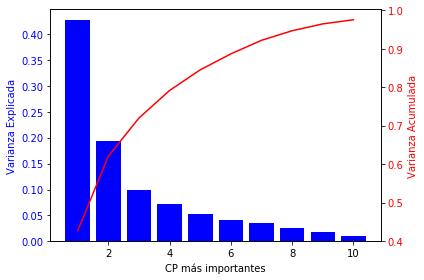

In [45]:
# visualizamos en un gráfico la proporción de la variabilidad explicada por los CP más importantes
fig, ax1 = plt.subplots()
ax1.set_xlabel('CP más importantes')
ax1.set_ylabel('Varianza Explicada', color='blue')
ax1.bar(components, autovalores, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Varianza Acumulada', color='red')
ax2.plot(components, autovalores_acum, color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

De acuerdo al gráfico anterior, los dos primeros autovalores (sus autovectores asociados), explican poco más del 60% de la variabilidad de los datos del dataset original.<br>
Corremos una última vez nuestro ejercicio de clusterización utilizando únicamente estos 2 componentes principales.

In [47]:
# creamos un nuevo dataset utilizando las dos primeras componentes principales
base_red = base_pca[:,0:2]

In [48]:
labels3 = []

In [60]:
# generamos sucesivos modelos de clusterización, en busca del hiperparámetro k que arroje el nro. óptimo de clusters
start_time = timeit.default_timer()
for num in range(2, 18):
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_red)
  labels3.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

46.56461734899858


In [61]:
labels3

[array([0, 0, 1, ..., 1, 1, 0], dtype=int32),
 array([1, 1, 0, ..., 0, 0, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([0, 0, 3, ..., 3, 3, 0], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 0, ..., 0, 0, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([ 0,  0, 13, ..., 13, 13,  0], dtype=int32),
 array([13, 13, 10, ..., 10, 10, 13], dtype=int32),
 array([ 1,  1, 12, ..., 12, 12,  1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32)]

In [62]:
scores3 = []

In [63]:
# evaluamos el SS para estos nuevos modelos
start_time = timeit.default_timer()
for res in range (1, 17):
  scores3.append(silhouette_score(base_red, labels3[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

4108.563881720998


In [64]:
scores3

[0.6948123844501959,
 0.9537002566845793,
 0.9626225812615614,
 0.9456499397551107,
 0.957260258587495,
 0.9725212567531111,
 0.9781522468295072,
 0.9833887971305246,
 0.9836173315610431,
 0.9849841705709166,
 0.9195765250791432,
 0.9172061817237913,
 0.7518519852661347,
 0.579531902606407,
 0.5756799829482252,
 0.5533122708492053]

In [65]:
# añadimos los scores al DataFrame
resultados['pca'] = scores3
resultados

,k,original,estandar,pca
0,2,0.502577,0.149954,0.694812
1,3,0.677233,0.276740,0.953700
2,4,0.741617,0.268479,0.962623
3,5,0.801972,0.376448,0.945650
4,6,0.840586,0.370748,0.957260
5,7,0.871688,0.449204,0.972521
6,8,0.894982,0.458170,0.978152
7,9,0.915882,0.520183,0.983389
8,10,0.930210,0.503786,0.983617
9,11,0.939197,0.528888,0.984984


In [66]:
# guardamos esta información en un csv para que pueda ser accedida sin tener que correr todo otra vez
resultados.to_csv('/Users/fer/Downloads/DATASCIENCE/CLUSTER AI/GRUPO TP/SUACI/resultados.csv')

In [77]:
# abalizamos los resultados para cada modelo
resultados.describe()

,k,original,estandar,pca
count,16.000000,16.000000,16.000000,16.000000
mean,9.500000,0.854459,0.458259,0.857117
std,4.760952,0.126787,0.133422,0.164941
min,2.000000,0.502577,0.149954,0.553312
25%,5.750000,0.799964,0.375023,0.737592
50%,9.500000,0.905432,0.511984,0.949675
75%,13.250000,0.947151,0.562464,0.973929
max,17.000000,0.955636,0.582908,0.984984


Algunas conclusiones preliminares:
- el mejor valor promedio del Silhouette Score se obtiene al correr Kmeans sobre la base obtenida a partir de los dos primeros componentes principales del dataset
- el máximo valor del SS se obtiene al correr sobre los componentes principales, con k=11
- al clusterizar sobre componentes principales, el SS devuelve resultados altos (en comparación con los otros dos subconjuntos) para valores bajos de k, lo cual resulta afín a nuestro propósito

**Objetivo 2**<br>
A partir de lo expuesto anteriormente, podemos inferir que al reducir la complejidad del dataset, permitimos al algoritmo Kmeans encontrar información más relevante a la hora de crear clusters. <br>
Para profundizar nuestro análisis, vamos a estudiar la clusterización sobre los componentes principales para los casos de k=11 (resultado óptimo), y k=3 (correspondiente al menor número de k que verifica SS > 0.95).

In [78]:
# corro por última vez los modelos de clusterización para extraer información adicional
kmeans_red_03 = KMeans(n_clusters=3, random_state=14).fit(base_red)
centers_red_03 = kmeans_red_03.cluster_centers_
labels_red_03 = kmeans_red_03.labels_

kmeans_red_11 = KMeans(n_clusters=11, random_state=14).fit(base_red)
centers_red_11 = kmeans_red_11.cluster_centers_
labels_red_11 = kmeans_red_11.labels_

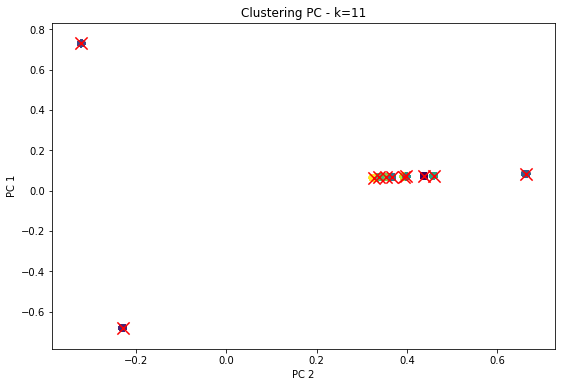

In [80]:
# Scatterplot: clustering con 2 PC - k=11
plt.figure(figsize=(9,6))
plt.scatter(base_red[:,1], base_red[:,0], c = labels_red_11.astype(float))
plt.scatter(centers_red_11[:,1], centers_red_11[:,0], marker = "x", color = 'r', s = 150)
plt.xlabel('PC 2')
plt.ylabel('PC 1')
plt.title('Clustering PC - k=11')
plt.show()

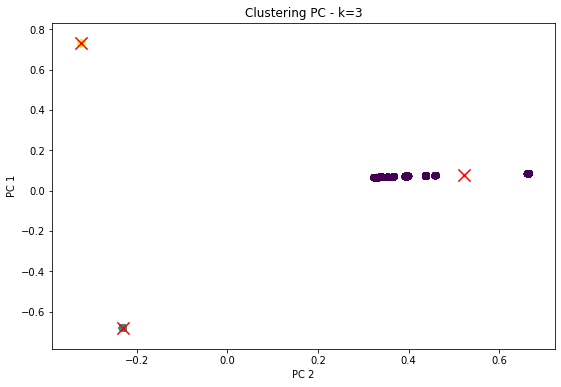

In [81]:
# Scatterplot: clustering con 2 PC - k=3
plt.figure(figsize=(9,6))
plt.scatter(base_red[:,1], base_red[:,0], c = labels_red_03.astype(float))
plt.scatter(centers_red_03[:,1], centers_red_03[:,0], marker = "x", color = 'r', s = 150)
plt.xlabel('PC 2')
plt.ylabel('PC 1')
plt.title('Clustering PC - k=3')
plt.show()

Al partir de la misma matriz de datos, la dispersión de los datos en el plano formado por las dos componentes principales es la misma en ambos casos. <br>
Lo que varía es el número de clusters, y por tanto la ubicación de los centroides, identificados con una x. <br>
Hay dos conjuntos de datos muy separados del resto, mientras que el resto parecieran ubicarse sobre una recta, próximos entre sí. <br>
Para k=3, se asigna un cluster propio a los conjuntos de datos que presentan mayor separación del resto (sobre la izquierda del gráfico), y agrupa al resto en un cluster. Al incrementar el número de clusters, se realizan divisiones adicionales sobre éste último conjunto.

Trataremos a continuación de analizar el criterio de agrupación de los contactos por parte del algoritmo.

In [86]:
# vamos a guardar la información de las etiquetas en el DataFrame Original (que contiene + información)
base_plot = base2019
base_plot['label03'] = labels_red_03
base_plot['label11'] = labels_red_11
base_plot.head(5)

,periodo,categoria,subcategoria,concepto,tipo_prestacion,fecha_ingreso,hora_ingreso,domicilio_cgpc,domicilio_barrio,domicilio_calle,domicilio_altura,domicilio_esquina_proxima,lat,long,canal,genero,estado_del_contacto,fecha_cierre_contacto,label03,label11
contacto,,,,,,,,,,,,,,,,,,,,
00000001/19,201901,TRÁNSITO,DENUNCIA VIAL,VEHÍCULO MAL ESTACIONADO,DENUNCIA,2019-01-01,12:11:17 a.m.,COMUNA 7,FLORES,"BONIFACIO, JOSE",2800.0,NaN,-34.634060,-58.466561,App,masculino,Cerrado,2019-01-02,1,1
00000002/19,201901,TRÁNSITO,DENUNCIA VIAL,VEHÍCULO MAL ESTACIONADO,DENUNCIA,2019-01-01,12:13:19 a.m.,COMUNA 6,CABALLITO,"BONIFACIO, JOSE",1108.0,NaN,-34.628162,-58.443378,App,masculino,Cerrado,2019-01-02,1,1
00000003/19,201901,ARBOLADO Y ESPACIOS VERDES,PLANTACIÓN DE ÁRBOL,PLANTACIÓN DE ÁRBOL,SOLICITUD,2019-01-01,12:23:32 a.m.,COMUNA 7,FLORES,MORON,2700.0,NaN,-34.623324,-58.469810,App,femenino,Cerrado,2019-01-11,0,3
00000005/19,201901,TRÁNSITO,DENUNCIA VIAL,VEHÍCULO MAL ESTACIONADO,DENUNCIA,2019-01-01,12:48:20 a.m.,COMUNA 6,CABALLITO,"GARCIA LORCA, FEDERICO",291.0,NaN,-34.618464,-58.445304,App,femenino,Cerrado,2019-01-03,1,1
00000006/19,201901,TRÁNSITO,DENUNCIA VIAL,VEHÍCULO MAL ESTACIONADO,DENUNCIA,2019-01-01,01:02:33 a.m.,COMUNA 10,VERSALLES,CUZCO,500.0,NaN,-34.634200,-58.528355,App,femenino,Cerrado,2019-01-03,1,1


In [87]:
# guardo esta info en un csv para que pueda ser accedida sin tener que correr todo otra vez
base_plot.to_csv('/Users/fer/Downloads/DATASCIENCE/CLUSTER AI/GRUPO TP/SUACI/base_plot.csv')

In [88]:
# analizo categorias por cluster - k=3
base_plot_cat03 = base_plot.groupby(['label03', 'categoria'])['lat'].count()
base_plot_cat03

label03  categoria                            
0        ALUMBRADO                                 24350
         ARBOLADO Y ESPACIOS VERDES                47818
         CALLES Y VEREDAS                          47715
         CEMENTERIOS                                  32
         CONTROL EDILICIO, OBRAS Y CATASTRO        16487
         FISCALIZACIÓN ACTIVIDADES COMERCIALES     11018
         MEDIOS DE TRANSPORTE                      17549
         ORDENAMIENTO DEL ESPACIO PÚBLICO           4607
         OTRAS                                      1022
         PLUVIALES                                  3366
         RECICLADO Y PROTECCIÓN AMBIENTAL           7984
         SALUD Y SERVICIOS SOCIALES                  128
         SEGURIDAD                                  3806
         SUGERENCIAS Y LIBRO DE QUEJAS              1180
         TRÁMITES Y SERVICIOS                      27469
1        TRÁNSITO                                 224426
2        LIMPIEZA Y RECOLECCIÓN          

In [89]:
# analizo categorias por cluster - k=11
base_plot_cat11 = base_plot.groupby(['label11', 'categoria'])['lat'].count()
base_plot_cat11

label11  categoria                            
0        ALUMBRADO                                 24350
1        TRÁNSITO                                 224426
2        LIMPIEZA Y RECOLECCIÓN                   187144
3        ARBOLADO Y ESPACIOS VERDES                47818
         CALLES Y VEREDAS                          47715
4        FISCALIZACIÓN ACTIVIDADES COMERCIALES     11018
5        MEDIOS DE TRANSPORTE                      17549
6        TRÁMITES Y SERVICIOS                      27469
7        ORDENAMIENTO DEL ESPACIO PÚBLICO           4607
         PLUVIALES                                  3366
         SEGURIDAD                                  3806
8        RECICLADO Y PROTECCIÓN AMBIENTAL           7984
9        CONTROL EDILICIO, OBRAS Y CATASTRO        16487
10       CEMENTERIOS                                  32
         OTRAS                                      1022
         SALUD Y SERVICIOS SOCIALES                  128
         SUGERENCIAS Y LIBRO DE QUEJAS   

Vemos que el algoritmo Kmeans clusterizó los contactos de acuerdo a su categoría, sin tener en consideración la posición geográfica de los mismos.<br>
A la hora de agrupar categorías en clusters, se agruparon aquellos con menor número de contactos, actuando los centroides como un baricentro de los mismos. <br>
La simplificación de la complejidad que trajo la aplicación de componentes principales resultó en una solución trivial de agrupación por categorías.

Para finalizar, vamos a plotear la clusterización para k=3 sobre el mapa.

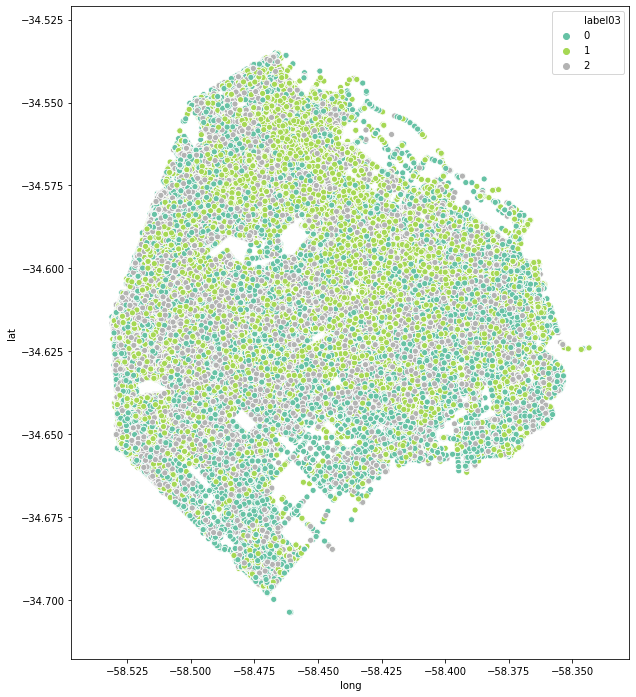

In [105]:
#  plot contactos, con distinción del cluster
plt.figure(figsize = (10,12))
sns.scatterplot(base_plot.long, base_plot.lat, hue = base_plot.label03, palette = 'Set2')
plt.show()

La distribución de los clusters es uniforme a lo largo de la superficie de la Ciudad. Remarcamos que la separación casi perfecta de los mismos se da en el plano de los 2 primeros componentes principales, no así en el definido por las coordenadas de latitud y longitud.